<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Разделение-на-train,-test" data-toc-modified-id="Разделение-на-train,-test-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разделение на train, test</a></span></li><li><span><a href="#Fit-MyDecisionTree" data-toc-modified-id="Fit-MyDecisionTree-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Fit MyDecisionTree</a></span></li><li><span><a href="#Predict-MyDecisionTree" data-toc-modified-id="Predict-MyDecisionTree-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Predict MyDecisionTree</a></span></li><li><span><a href="#Train-with-sklearn" data-toc-modified-id="Train-with-sklearn-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train with sklearn</a></span></li><li><span><a href="#Сравнение-метрик" data-toc-modified-id="Сравнение-метрик-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Сравнение метрик</a></span></li></ul></div>

# Задание  

1. Напишите свой алгоритм построения дерева решений для задачи бинарной классификации.  
    - критерий информативности - Энтропия Шеннона
    - критерии останова - максимальная глубина, кол-во элементов в листе, прирост энтропии < x
2. Сравните результат работы своего алгоритма с sklearn    

3. (дополнительно)  Попробуйте не делать One-Hot-Encoding для категориальных переменных, а добавить их обработку в свой алгоритм. Сравните качество работы алгоритма с предыдущим решением.

## Подготовка данных
Рассмотрим задачу "Титаник" https://www.kaggle.com/c/titanic/data. Необходимо предсказать выживет пассажир или нет.

In [26]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix 

In [27]:
# считаем данные из файла в pandas DataFrame
df = pd.read_csv("train.csv")

# зафиксируем целевую переменную и удалим ее из данных
y = df['Survived']
target_name = 'Survived'
#df.drop('Survived', axis=1, inplace=True)

In [28]:
# удалим признаки PassengerId, Name, Ticket и Cabin из данных
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# заполним пропуски в признаке Age обучающей выборки медианным значением
df['Age'].fillna(df['Age'].median(), inplace=True)

#заполним пропуски в признаке Embarked обучающей выборки самыми частыми значениями этого признака
df['Embarked'].fillna(df['Embarked'].value_counts().idxmax(), inplace=True)

#заменим категориальные признаки, используя One-Hot-Encoding
categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)

df.drop(categorical, axis=1, inplace=True)

In [29]:
df.head()

,Survived,Age,Fare,Pclass_2,Pclass_3,Sex_male,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S
0,0,22.0,7.2500,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,38.0,71.2833,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,26.0,7.9250,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,1,35.0,53.1000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,35.0,8.0500,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## Разделение на train, test

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [31]:
print ('Train: ' + str(len(X_train)))
print ('Test: ' + str(len(X_test)))

Train: 801
Test: 90


## Fit MyDecisionTree  
Напишите свою функцию построения дерева.

Структуру дерева можно задать, например, словарем следующего вида:  
```python
{'feature_name': 'Age', # название фичи 
'threshold': 20, # порог разбиения
'left': 0,  # ссылка на левое поддерево, задан доминирующий класс
'right': 1} # ссылка на правое поддерево, задан доминирующий класс
```

In [32]:
def get_target(df):
    """
        Функция ищет доминирующий класс во входном DataFrame
        Input - DataFrame
        Output - 0 или 1
        
        Например, в исходных данных 490 нулей и 311 единиц.
        Функция должна вернуть 0.
    """
    
    if df[target_name].value_counts().shape[0] == 1:
        if (df[target_name].values[0] == 0): return 0
        else: return 1
    zeros = df[target_name].value_counts().values[0]
    ones = df[target_name].value_counts().values[1]
    if zeros > ones: return 0
    else: return 1
    


def get_entropy(target):
    """
        Функция считает энтропию заданного множества.
        Input - таргет (тип - pandas.core.series.Series)
        
        Output - значение энтропии (тип - float)
    """
    
    if target.value_counts().shape[0] == 1:
        return 0
    
    zeros = target.value_counts().values[0]
    ones = target.value_counts().values[1]
    zerosc =  zeros / (zeros + ones)
    onesc =  ones / (zeros + ones)
    entropy = -zerosc * np.log2(zerosc) - onesc * np.log2(onesc)
    #print('entropy = ', entropy)
    return entropy



def feature_separation(df, f_name):
    """
        Функция ищет лучшее разбиение для данной фичи.
        Input - df: DataFrame с 2 атрибутами (feature, target), 
                f_name: название фичи (для которой ищем разбиение)
                
        Output - прирост энтропии, порог разбиения
    """
    
    # YOUR CODE HERE
    ig = get_entropy(df[target_name])
    delta_entropy = 0
    threshold = 0
    if df[f_name].value_counts().shape[0] == 2:
        for i in range(1, df.shape[0]):
            if df[f_name].values[i] == 1:
                lentr = get_entropy(df[target_name][:i])
                rentr = get_entropy(df[target_name][i:])
                lsize = i / df[f_name].shape[0]
                rsize = (df[f_name].shape[0] - i) / df[f_name].shape[0]
                delta_entropy = ig  - lentr * lsize - rentr * rsize
                threshold = i
                break
    else:
        for i in range(1, df.shape[0]):
            lentr = get_entropy(df[target_name][:i])
            rentr = get_entropy(df[target_name][i:])
            lsize = i / df[f_name].shape[0]
            rsize = (df[f_name].shape[0] - i) / df[f_name].shape[0]
            if (ig  - lentr * lsize - rentr * rsize > delta_entropy):
                delta_entropy = ig  - lentr * lsize - rentr * rsize
                threshold = i
    return (delta_entropy, threshold)


def best_separation(df):
    """
        Функция выбирает фичу для разбиения, которая даст максимальный прирост энтропии.
        Input - исходный DataFrame
        
        Output - словарь следующиего вида
        {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}
        
            sep_feature - название фичи для разбиения (тип - String)
            threshold - порог разбиения (тип - float)
            groups - tuple из двух поддеревьев (df_left, df_right)
    """
    
    sep_feature, threshold, groups = None, None, df
    all_features = [c for c in df.columns.tolist() if c != 'target']
    best_entr = 0
    for f in all_features:
        # YOUR CODE HERE
        if f != target_name:
            df = df.sort_values(by=[f], ascending=True)
            curdf = df[[f, target_name]].copy()
            #print(curdf.head)
            delta_entropy, resthreshold = feature_separation(df, f)
            #print('delta entr = ', delta_entropy)
            if (delta_entropy > best_entr):
                best_entr = delta_entropy
                sep_feature = f
                threshold = resthreshold
                groups = df[:threshold], df[threshold:]
    return {'feature_name': sep_feature, 'threshold': threshold, 'groups': groups}


def split(node, max_depth, depth):
    """
        Рекурсивная функция для построения дерева
        Input - node: корень дерева
                max_depth: максимальная глубина дерева
                depth: текущая глубина дерева
    """
    df_left, df_right = node['groups']
    sep_feature = node['feature_name']
    del(node['groups'])
    
    # проверяем, есть ли разбиение
    if len(df_left) == 0 or len(df_right) == 0:
        node['left'] = get_target(df_left)
        node['right'] = get_target(df_right)
        return
    
    # проверяем максимальную глубину
    if depth >= max_depth:
        node['left'] = get_target(df_left)
        node['right'] = get_target(df_right)
        return
    
    else:
        node['left'] = best_separation(df_left)
        split(node['left'], max_depth, depth + 1)

        node['right'] = best_separation(df_right)
        split(node['right'], max_depth, depth + 1)
        
        
def fit_my_tree(df, max_depth):
    """
        Функция для обучения дерева
        Input - df: DataFrame
                max_depth: максимальная глубина дерева
    """    
    root = best_separation(df)
    split(root, max_depth, 1)

    return root

In [33]:
my_tree = fit_my_tree(X_train, 3)

## Predict MyDecisionTree  

In [34]:
def predict_raw(row, tree):
    """
        Функция предсказывает класс для 1 строки DataFrame.
        
        Input - row: строка DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
    """    
    if row[tree['feature_name']] <= tree['threshold']:
        if type(tree['left']) == dict:
            return predict_raw(row, tree['left'])
        else:
            return tree['left']
    else:
        if type(tree['right']) == dict:
            return predict_raw(row, tree['right'])
        else:
            return tree['right']
    
    
def predict_my_tree(df, tree):
    """
        Функция предсказывает класс для исходного DataFrame.
        
        Input - df: исходный DataFrame
                tree: обученное дерево на предыдущем шаге (тип - dict)
                
        Output - предсказанные классы (тип - pandas.core.series.Series)
    """      
    predict = pd.Series()   
    for index, row in df.iterrows():
        prediction = pd.Series(predict_raw(row, my_tree), [index])
        predict = predict.append(prediction)    
        
    return predict

In [35]:
my_pred_test = predict_my_tree(X_test, my_tree)
my_pred_train = predict_my_tree(X_train, my_tree)

<ipython-input-34-502e52ba210a>:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predict = pd.Series()


In [37]:
print (np.mean(my_pred_test == y_test))
print(np.mean(my_pred_train == y_train))

0.34444444444444444
0.3882646691635456


## Train with sklearn 

Обучите дерево, используя библиотеку sklearn. Задайте те же параметры, что и при обучении своего дерева.  

Сравните метрики и попробуйте улучшить ваше дерево.

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import *

In [39]:
df.drop(['Survived'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.1, random_state = 13)

In [42]:
clf_tree = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=3)

# обучаем дерево
clf_tree.fit(X_train, y_train)

# предсказание на тестовой и обучающей выборках
y_pred_test = clf_tree.predict(X_test)
y_pred_train = clf_tree.predict(X_train)

[Text(465.0, 792.75, 'Sex_male <= 0.5\nentropy = 0.964\nsamples = 801\nvalue = [490, 311]'),
 Text(232.5, 566.25, 'Pclass_3 <= 0.5\nentropy = 0.821\nsamples = 281\nvalue = [72, 209]'),
 Text(116.25, 339.75, 'Fare <= 28.856\nentropy = 0.324\nsamples = 152\nvalue = [9, 143]'),
 Text(58.125, 113.25, 'entropy = 0.52\nsamples = 60\nvalue = [7, 53]'),
 Text(174.375, 113.25, 'entropy = 0.151\nsamples = 92\nvalue = [2, 90]'),
 Text(348.75, 339.75, 'Fare <= 24.808\nentropy = 1.0\nsamples = 129\nvalue = [63, 66]'),
 Text(290.625, 113.25, 'entropy = 0.978\nsamples = 109\nvalue = [45, 64]'),
 Text(406.875, 113.25, 'entropy = 0.469\nsamples = 20\nvalue = [18, 2]'),
 Text(697.5, 566.25, 'Fare <= 26.269\nentropy = 0.714\nsamples = 520\nvalue = [418, 102]'),
 Text(581.25, 339.75, 'Age <= 13.5\nentropy = 0.567\nsamples = 367\nvalue = [318, 49]'),
 Text(523.125, 113.25, 'entropy = 0.592\nsamples = 14\nvalue = [2, 12]'),
 Text(639.375, 113.25, 'entropy = 0.484\nsamples = 353\nvalue = [316, 37]'),
 Text(8

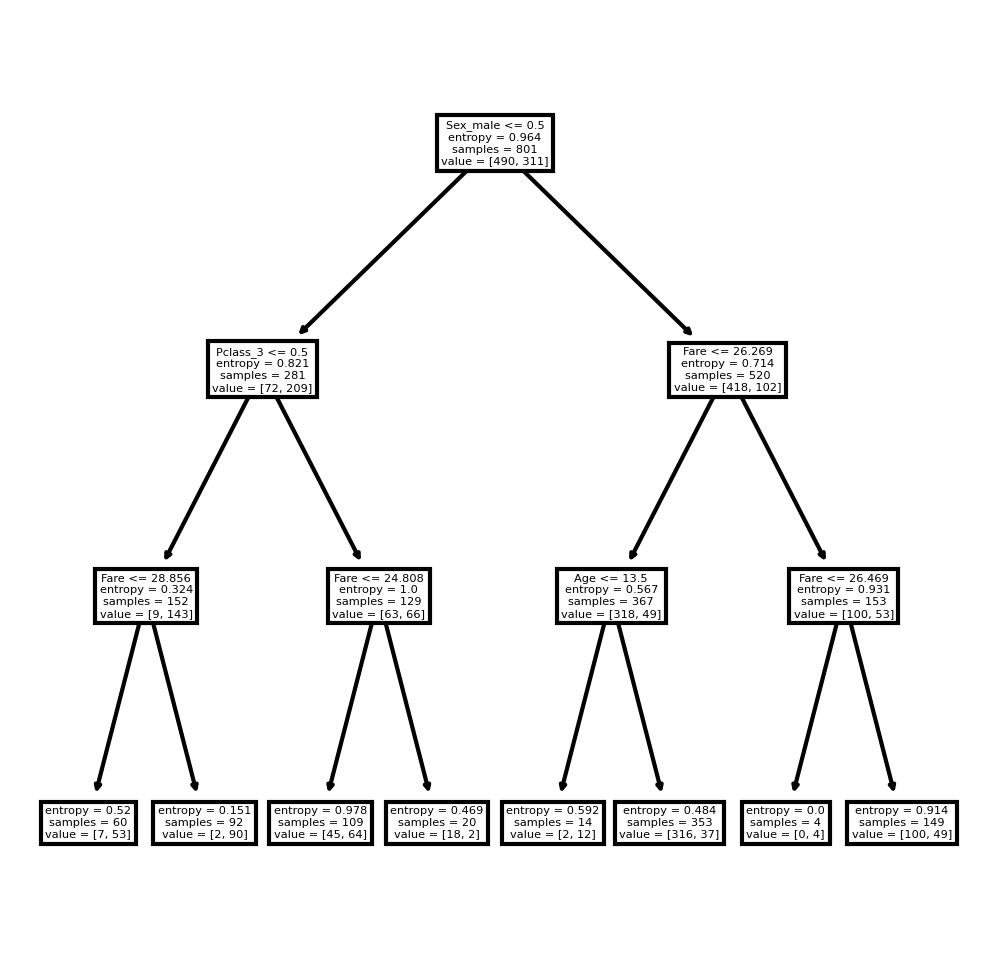

In [43]:
import matplotlib.pyplot as plt
from sklearn import tree
#Отрисовать дерево можно вот так:   
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf_tree, feature_names = X_train.columns)

## Сравнение метрик

In [44]:
# метрики при обучении, используя библиотеку sklearn
skl_roc_train = roc_auc_score(y_train, y_pred_train)
skl_roc_test = roc_auc_score(y_test, y_pred_test)

# метрики при обучении, используя собственный алгоритм
my_roc_train = roc_auc_score(y_train, my_pred_train)
my_roc_test = roc_auc_score(y_test, my_pred_test)

In [45]:
print(my_roc_test)
assert abs(my_roc_test - 0.6) >= 0.2

0.5


AssertionError: 

In [46]:
print(abs(my_roc_test - 0.6) >= 0.2)

False


In [47]:
print (np.mean(my_pred_test == y_test))
print (np.mean(y_pred_test == y_test))

0.34444444444444444
0.8666666666666667
